In [85]:
from utils import gcs_utils as gcs
from utils import model_and_evaluate_cluster as ev

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import importlib
import hdbscan
from sklearn.cluster import DBSCAN
import io
import os
import pickle
import datetime


from sklearn.neighbors import NearestNeighbors
import seaborn as sns
sns.set()

from sklearn.cluster import KMeans
from kneed import KneeLocator

# Models Generated



|            | [1] DeepFold | [2] SeqVec |
|------------|--------------|------------|
| A. DBSCAN  | A1 | A2 |
| B. HDBSCAN | B1 | B2 |
| C. OPTICS  | C1 | C2 |



Model files generated

```
Upload: model_outputs/A1-DBSCAN-DeepFold-cluster_stats.parquet
Upload: model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
Upload: model_outputs/a1_model.pkl
Upload: model_outputs/A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet
Upload: model_outputs/B1-HDBSCAN-DeepFold-cluster_stats.parquet
Upload: model_outputs/b2_model.pkl
Upload: model_outputs/B2-HDBSCAN-SeqVec-cluster_stats.parquet
Upload: model_outputs/a2_model.pkl
Upload: model_outputs/b1_model.pkl
Upload: model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
Upload: model_outputs/B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet
Upload: model_outputs/A2-DBSCAN-SeqVec-cluster_stats.parquet
```

In [2]:
prefix='model_outputs/no_cluster_size_limit/'
a1_model = gcs.download_pkl(prefix+'A1_model.pkl')
a2_model = gcs.download_pkl(prefix+'A2_model.pkl')
a3_model = gcs.download_pkl(prefix+'A3_model.pkl')
b1_model = gcs.download_pkl(prefix+'B1_model.pkl')
b2_model = gcs.download_pkl(prefix+'B2_model.pkl')
b3_model = gcs.download_pkl(prefix+'B3_model.pkl')


In [3]:

a1_clusters = gcs.download_pkl(prefix+'A1_clusters.pkl')
a2_clusters = gcs.download_pkl(prefix+'A2_clusters.pkl')
a3_clusters = gcs.download_pkl(prefix+'A3_clusters.pkl')
b1_clusters = gcs.download_pkl(prefix+'B1_clusters.pkl')
b2_clusters = gcs.download_pkl(prefix+'B2_clusters.pkl')
b3_clusters = gcs.download_pkl(prefix+'B3_clusters.pkl')


In [6]:

a1_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet')
a2_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet')
# a3_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'A3-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet')
b1_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet')
b2_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet')
# b3_all_protein_combos_per_cluster = gcs.download_parquet(prefix+'B3-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet')


In [5]:
b1_clusters

,protein,cluster_label
0,Q53HV7,434
1,A4UGR9,-1
2,P09529,-1
3,P19622,-1
4,Q9UPU9,-1
...,...,...
20296,Q9NQ76,-1
20297,A6NKD9,580
20298,Q9UPR3,-1
20299,Q9NZZ3,-1


## Output Data Review

In [193]:
a1_all_protein_combos_per_cluster.shape

(29886034, 3)

In [194]:
a1_all_protein_combos_per_cluster.head()

,query_protein,target_protein,cluster
1,P09529,Q9UPU9,0
2,P09529,Q9HCL3,0
3,P09529,Q2I0M5,0
4,P09529,Q9Y639,0
5,P09529,Q8IWF6,0


In [199]:
pivot = a1_all_protein_combos_per_cluster.pivot_table(index='cluster',
                                             values=['target_protein', 'query_protein'],
                                             aggfunc=pd.Series.nunique)
pivot.sort_values('query_protein', ascending=False)

,query_protein,target_protein
cluster,,
0,5447,5447
23,250,250
35,211,211
12,179,179
19,110,110
...,...,...
578,2,2
582,2,2
583,2,2


In [200]:
pivot = a2_all_protein_combos_per_cluster.pivot_table(index='cluster',
                                             values=['target_protein', 'query_protein'],
                                             aggfunc=pd.Series.nunique)
pivot.sort_values('query_protein', ascending=False)

,query_protein,target_protein
cluster,,
28,691,691
19,426,426
107,152,152
151,127,127
329,103,103
...,...,...
764,2,2
765,2,2
767,2,2


In [201]:
pivot = b1_all_protein_combos_per_cluster.pivot_table(index='cluster',
                                             values=['target_protein', 'query_protein'],
                                             aggfunc=pd.Series.nunique)
pivot.sort_values('query_protein', ascending=False)

,query_protein,target_protein
cluster,,
519,308,308
550,254,254
486,126,126
436,124,124
432,85,85
...,...,...
297,5,5
467,5,5
294,5,5


In [202]:
pivot = b2_all_protein_combos_per_cluster.pivot_table(index='cluster',
                                             values=['target_protein', 'query_protein'],
                                             aggfunc=pd.Series.nunique)
pivot.sort_values('query_protein', ascending=False)

,query_protein,target_protein
cluster,,
579,416,416
578,195,195
755,129,129
421,99,99
667,89,89
...,...,...
451,5,5
180,5,5
625,5,5


In [206]:

def get_noise_stats(model):
    labels = np.unique(model.labels_, return_counts=True)
    noise_ct = labels[1][0]
    max_cluster_size = labels[1][1:].max()
    num_proteins=model.labels_.shape[0]


    return {"Number of clusters categories (incl. noise)": np.unique(model.labels_, return_counts=True)[1].shape[0],
            "Number of clusters (excl. noise)": np.unique(model.labels_, return_counts=True)[1].shape[0]-1,
            "Noise": noise_ct,
            "Largest non-noise cluster": max_cluster_size,
            "Noise as % of total":  noise_ct/num_proteins,
            "Noise and largest cluster as % of total": (noise_ct+max_cluster_size)/num_proteins}


In [207]:
get_noise_stats(a1_model)

{'Number of clusters categories (incl. noise)': 1223,
 'Number of clusters (excl. noise)': 1222,
 'Noise': 10240,
 'Largest non-noise cluster': 5451,
 'Noise as % of total': 0.504408649820206,
 'Noise and largest cluster as % of total': 0.7729175902664893}

In [208]:
get_noise_stats(a2_model)

{'Number of clusters categories (incl. noise)': 1607,
 'Number of clusters (excl. noise)': 1606,
 'Noise': 12966,
 'Largest non-noise cluster': 691,
 'Noise as % of total': 0.6323644166991806,
 'Noise and largest cluster as % of total': 0.6660651580179477}

In [209]:
get_noise_stats(b1_model)

{'Number of clusters categories (incl. noise)': 608,
 'Number of clusters (excl. noise)': 607,
 'Noise': 14056,
 'Largest non-noise cluster': 308,
 'Noise as % of total': 0.692379685729767,
 'Noise and largest cluster as % of total': 0.7075513521501404}

In [210]:
get_noise_stats(b2_model)

{'Number of clusters categories (incl. noise)': 758,
 'Number of clusters (excl. noise)': 757,
 'Noise': 11579,
 'Largest non-noise cluster': 416,
 'Noise as % of total': 0.5647190792040577,
 'Noise and largest cluster as % of total': 0.5850078033554429}

# Input Data Generation

## 1-EP DeepFold Excluding Low-Confidence Proteins

In [27]:
prefix = 'embeddings/DeepFold/withMask=false/'
keys = gcs.list_file_paths(prefix)[1:]

In [28]:
keys

['gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_00.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_01.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_02.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_03.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_04.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_05.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_06.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_07.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_08.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_09.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_10.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/wit

In [29]:
X_deepfold, missing_deepfold, protein_id_deepfold = ev.import_deepfold_embeddings(keys)

embeddings/DeepFold/withMask=false/embeddings_00.csv
embeddings/DeepFold/withMask=false/embeddings_01.csv
embeddings/DeepFold/withMask=false/embeddings_02.csv
embeddings/DeepFold/withMask=false/embeddings_03.csv
embeddings/DeepFold/withMask=false/embeddings_04.csv
embeddings/DeepFold/withMask=false/embeddings_05.csv
embeddings/DeepFold/withMask=false/embeddings_06.csv
embeddings/DeepFold/withMask=false/embeddings_07.csv
embeddings/DeepFold/withMask=false/embeddings_08.csv
embeddings/DeepFold/withMask=false/embeddings_09.csv
embeddings/DeepFold/withMask=false/embeddings_10.csv
embeddings/DeepFold/withMask=false/embeddings_11.csv
embeddings/DeepFold/withMask=false/embeddings_12.csv
embeddings/DeepFold/withMask=false/embeddings_13.csv
embeddings/DeepFold/withMask=false/embeddings_14.csv
embeddings/DeepFold/withMask=false/embeddings_15.csv
embeddings/DeepFold/withMask=false/embeddings_16.csv
embeddings/DeepFold/withMask=false/embeddings_17.csv
embeddings/DeepFold/withMask=false/embeddings_

In [30]:
print("X_deepfold.shape", X_deepfold.shape)
print("missing_deepfold.shape", missing_deepfold.shape)
print("protein_id_deepfold.shape", protein_id_deepfold.shape)

X_deepfold.shape (20301, 398)
missing_deepfold.shape (203,)
protein_id_deepfold.shape (20301,)


(100, 100)
0.08846894787860533 1.3914903332683621 1.1233384707829146


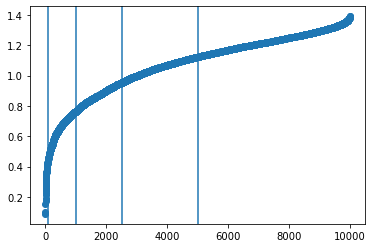

In [31]:
# Show euclidean distances between a random set of points

ed = euclidean_distances(X_deepfold[np.random.choice(range(len(X_deepfold)), 100)],
                         X_deepfold[np.random.choice(range(len(X_deepfold)), 100)]
                        )
print(ed.shape)

min_ed = np.min(ed)
max_ed = np.max(ed)
median_ed = np.median(ed)

print(min_ed, max_ed, median_ed)
ed_flatten = ed.flatten()

plt.scatter(range(len(ed_flatten)), np.sort(ed_flatten))
plt.axvline(len(ed_flatten)/2)
plt.axvline(len(ed_flatten)/4)
plt.axvline(len(ed_flatten)/10)
plt.axvline(len(ed_flatten)/100)
plt.show()

(array([  2.,   0.,   1.,   4.,   1.,   2.,   2.,   4.,   5.,   5.,  13.,
         12.,  20.,  27.,  27.,  24.,  47.,  45.,  38.,  56.,  83.,  78.,
        103., 121., 136., 151., 149., 162., 207., 227., 210., 224., 258.,
        271., 319., 316., 379., 440., 465., 524., 575., 579., 676., 674.,
        647., 577., 490., 351., 211.,  62.]),
 array([0.08846895, 0.11452938, 0.1405898 , 0.16665023, 0.19271066,
        0.21877109, 0.24483151, 0.27089194, 0.29695237, 0.3230128 ,
        0.34907322, 0.37513365, 0.40119408, 0.42725451, 0.45331494,
        0.47937536, 0.50543579, 0.53149622, 0.55755665, 0.58361707,
        0.6096775 , 0.63573793, 0.66179836, 0.68785879, 0.71391921,
        0.73997964, 0.76604007, 0.7921005 , 0.81816092, 0.84422135,
        0.87028178, 0.89634221, 0.92240263, 0.94846306, 0.97452349,
        1.00058392, 1.02664435, 1.05270477, 1.0787652 , 1.10482563,
        1.13088606, 1.15694648, 1.18300691, 1.20906734, 1.23512777,
        1.26118819, 1.28724862, 1.31330905, 1.

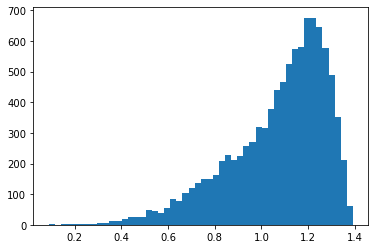

In [32]:
plt.hist(ed_flatten, bins=50)

The euclidean distance among the proteins range from 0 to 1.41, median is about 1.12. And based on the plot of euclidean distances, it appears that there are a lot of proteins that are similar to each other and there is a long tail of different proteins. 

Start with DeepFold embed

Download confidence per protein

In [37]:
protein_conf = gcs.download_parquet('structure_files/proteins_and_confidences.parquet')

In [52]:
protein_conf.shape

(20504, 3)

In [22]:
protein_conf.confidence.value_counts()

M    10981
L     5554
H     2980
D      989
Name: confidence, dtype: int64

In [25]:
protein_conf[protein_conf.confidence!='D'].shape

(19515, 3)

Create a mask to filter for the positions in protein_id_deepfold if that protein has a plDDT > 50 

In [71]:
mask = np.isin(protein_id_deepfold,
               np.array(protein_conf[protein_conf.confidence!='D'].protein_id)
              )


In [72]:
print(mask.shape)
print(protein_id_deepfold.shape)
print(protein_id_deepfold[mask].shape)
print(X_deepfold.shape)
print(X_deepfold[mask].shape)

(20301,)
(20301,)
(19299,)
(20301, 398)
(19299, 398)


In [73]:
protein_id_deepfold_ep = protein_id_deepfold[mask]
X_deepfold_ep = X_deepfold[mask]

## 2-EP SeqVec Excluding Low-Confidence Proteins

In [34]:
prefix = 'embeddings/SeqVec/'
keys = gcs.list_file_paths(prefix)

# There's only one file 
key = gcs.uri_to_bucket_and_key(keys[1])[1]
seqvec_df = gcs.download_pkl(key)

# Convert pd Series into np arr
X_seqvec = np.stack( seqvec_df["seqvec"]).astype(np.float64)

X_seqvec.shape

(20504, 1024)

In [35]:
protein_id_seqvec = np.array(seqvec_df["protein_id"])
protein_id_seqvec.shape

(20504,)

In [38]:
mask = np.isin(protein_id_seqvec,
               np.array(protein_conf[protein_conf.confidence!='D'].protein_id)
              )


In [39]:
print(mask.shape)
print(protein_id_seqvec.shape)
print(protein_id_seqvec[mask].shape)
print(X_seqvec.shape)
print(X_seqvec[mask].shape)

(20504,)
(20504,)
(19515,)
(20504, 1024)
(19515, 1024)


In [40]:
protein_id_seqvec_ep = protein_id_seqvec[mask]
X_seqvec_ep = X_seqvec[mask]

(100, 100)
8.429369702178807e-08 14.268128240485407 4.076347963175348


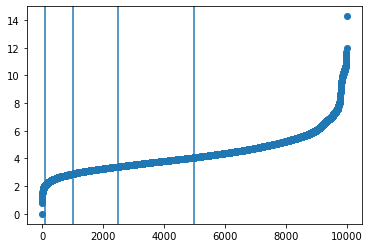

In [41]:
# Show euclidean distances between a random set of points

ed = euclidean_distances(X_seqvec[np.random.choice(range(len(X_seqvec)), 100)],
                         X_seqvec[np.random.choice(range(len(X_seqvec)), 100)]
                        )
print(ed.shape)

min_ed = np.min(ed)
max_ed = np.max(ed)
median_ed = np.median(ed)

print(min_ed, max_ed, median_ed)
ed_flatten = ed.flatten()

plt.scatter(range(len(ed_flatten)), np.sort(ed_flatten))
plt.axvline(len(ed_flatten)/2)
plt.axvline(len(ed_flatten)/4)
plt.axvline(len(ed_flatten)/10)
plt.axvline(len(ed_flatten)/100)
plt.show()

(array([1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 6.000e+00, 9.000e+00,
        5.400e+01, 1.350e+02, 2.410e+02, 4.580e+02, 6.690e+02, 9.480e+02,
        1.050e+03, 1.113e+03, 9.950e+02, 8.720e+02, 6.810e+02, 5.920e+02,
        4.710e+02, 3.960e+02, 2.740e+02, 1.760e+02, 1.450e+02, 1.380e+02,
        1.280e+02, 1.000e+02, 7.100e+01, 3.500e+01, 2.400e+01, 1.100e+01,
        8.000e+00, 8.000e+00, 1.200e+01, 2.100e+01, 2.600e+01, 4.500e+01,
        4.200e+01, 2.600e+01, 1.000e+01, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([8.42936970e-08, 2.85362647e-01, 5.70725211e-01, 8.56087774e-01,
        1.14145034e+00, 1.42681290e+00, 1.71217546e+00, 1.99753803e+00,
        2.28290059e+00, 2.56826315e+00, 2.85362572e+00, 3.13898828e+00,
        3.42435084e+00, 3.70971340e+00, 3.99507597e+00, 4.28043853e+00,
        4.56580109e+00, 4.85116366e+00, 5.13652622e+00, 5.42188878e+00,
        5.707251

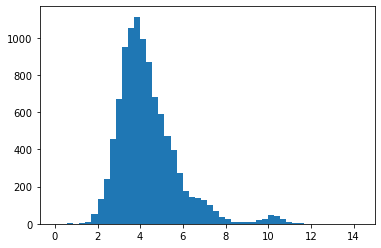

In [42]:
plt.hist(ed_flatten, bins=50)

## 3 CurveNet

In [4]:
prefix = 'embeddings/CurveNet/'
keys = gcs.list_file_paths(prefix)

# There's only one file 
key = gcs.uri_to_bucket_and_key(keys[1])[1]
curvenet_df = gcs.download_parquet(key)

In [5]:
curvenet_df

,protein_id,curvenet_embeddings,goa_parent_labels,pred_prob
0,A6NKX1,"[3.562437007945123e-40, 0.0, 0.0, 1.7012421967...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.296404510270804e-05, 0.01053694263100624, 0..."
1,Q96H35,"[3.562437007945123e-40, 0.0, 0.208125561475753...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.006045132409781218, 0.1224650889635086, 0.0..."
2,Q7L8C5,"[3.562437007945123e-40, 0.0, 0.200734496116638...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0006366354646161199, 0.4344342052936554, 0...."
3,Q9BSK4,"[3.562437007945123e-40, 0.0, 0.099959425628185...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0012441753642633557, 0.49110904335975647, 0..."
4,A6NKN8,"[3.562437007945123e-40, 0.0, 0.059203766286373...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0005818138015456498, 0.15333041548728943, 0..."
...,...,...,...,...
20475,A0A1W2PQF6,"[3.562437007945123e-40, 0.0, 0.194861769676208...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0009753310005180538, 0.22738836705684662, 0..."
20476,O75575,"[3.562437007945123e-40, 0.0, 0.198050335049629...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0011264118365943432, 0.23158062994480133, 0..."
20477,Q96DC9,"[3.562437007945123e-40, 0.0, 0.039628043770790...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0012927342904731631, 0.8860936760902405, 0...."
20478,Q96CD2,"[3.562437007945123e-40, 0.0, 0.178121879696846...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.002835633000358939, 0.8538557887077332, 0.0..."


In [6]:
# Convert pd Series into np arr
X_curvenet = np.stack( curvenet_df["curvenet_embeddings"]).astype(np.float64)

X_curvenet.shape

(20480, 1024)

In [7]:
protein_id_curvenet = np.array(curvenet_df["protein_id"])
protein_id_curvenet.shape

(20480,)

(100, 100)
0.21670003339466676 2.1095625980476997 0.6699137859046514


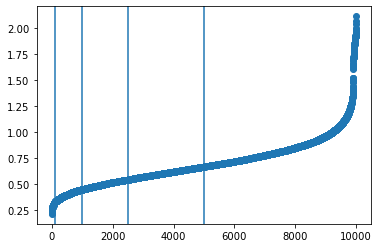

In [17]:
# Show euclidean distances between a random set of points

ed = euclidean_distances(X_curvenet[np.random.choice(range(len(X_curvenet)), 100)],
                         X_curvenet[np.random.choice(range(len(X_curvenet)), 100)]
                        )
print(ed.shape)

min_ed = np.min(ed)
max_ed = np.max(ed)
median_ed = np.median(ed)

print(min_ed, max_ed, median_ed)
ed_flatten = ed.flatten()

plt.scatter(range(len(ed_flatten)), np.sort(ed_flatten))
plt.axvline(len(ed_flatten)/2)
plt.axvline(len(ed_flatten)/4)
plt.axvline(len(ed_flatten)/10)
plt.axvline(len(ed_flatten)/100)
plt.show()

(array([  4.,  26.,  74., 176., 265., 358., 523., 596., 702., 755., 776.,
        769., 787., 677., 599., 574., 454., 386., 324., 251., 191., 164.,
        113.,  88.,  86.,  52.,  37.,  40.,  25.,   9.,   7.,   3.,   2.,
          3.,   3.,   0.,   2.,   4.,   2.,  11.,   6.,   8.,  12.,  18.,
         17.,  13.,   4.,   1.,   2.,   1.]),
 array([0.21670003, 0.25455728, 0.29241454, 0.33027179, 0.36812904,
        0.40598629, 0.44384354, 0.48170079, 0.51955804, 0.5574153 ,
        0.59527255, 0.6331298 , 0.67098705, 0.7088443 , 0.74670155,
        0.7845588 , 0.82241605, 0.86027331, 0.89813056, 0.93598781,
        0.97384506, 1.01170231, 1.04955956, 1.08741681, 1.12527406,
        1.16313132, 1.20098857, 1.23884582, 1.27670307, 1.31456032,
        1.35241757, 1.39027482, 1.42813207, 1.46598933, 1.50384658,
        1.54170383, 1.57956108, 1.61741833, 1.65527558, 1.69313283,
        1.73099009, 1.76884734, 1.80670459, 1.84456184, 1.88241909,
        1.92027634, 1.95813359, 1.99599084, 2.

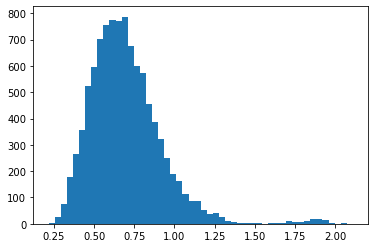

In [24]:
plt.hist(ed_flatten, bins=50)

In [74]:
mask = np.isin(protein_id_curvenet,
               np.array(protein_conf[protein_conf.confidence!='D'].protein_id)
              )

print(mask.shape)
print(protein_id_curvenet.shape)
print(protein_id_curvenet[mask].shape)
print(X_curvenet.shape)
print(X_curvenet[mask].shape)

protein_id_curvenet_ep = protein_id_curvenet[mask]
X_curvenet_ep = X_curvenet[mask]

(20480,)
(20480,)
(19491,)
(20480, 1024)
(19491, 1024)


# Modeling


## Elbow Method on K Means

Try to see what the optimal number of clusters should be using the Elbow method. 

In [164]:
distortions = []
k = 2 
K=[]
while k <= 512:
    K.append(k)
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_deepfold_ep)
    distortions.append(kmeanModel.inertia_)
    print(k, kmeanModel.inertia_)
    k *= 2
    



2 10220.924910729955
4 8960.463358383215
8 8020.564783218223
16 6926.668875771909
32 6150.108729563036
64 5498.673642697684
128 4931.38199741465
256 4384.057429753001
512 3834.865382832602


In [177]:
distortions_plus = []
k = 32 + 4
J=[]
while k <= 64+32:
    J.append(k)
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_deepfold_ep)
    distortions_plus.append(kmeanModel.inertia_)
    print(k, kmeanModel.inertia_)
    k += 4

36 6034.888181159382
40 5926.4105136073795
44 5833.045994374483
48 5750.728122461115
52 5677.571734470904
56 5613.093577159669
60 5559.901747400745
64 5496.369575571896
68 5439.688725896976
72 5387.562400167304
76 5343.152701251282
80 5306.974886752055
84 5259.026804256996
88 5217.715375040006
92 5186.944307157194
96 5157.855267175275


In [207]:
JK = J + K
distortions_all = distortions_plus + distortions 
sorted_index = sorted(range(len(JK)), key=lambda k: JK[k])
JK = [JK[i] for i in sorted_index]
distortions_all = [distortions_all[i] for i in sorted_index]

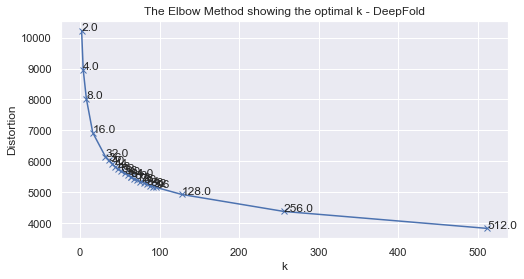

In [208]:
plt.figure(figsize=(8,4))
Y = distortions_all
X = JK
plt.plot(X, Y, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k - DeepFold')

for i, label in enumerate(X):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

72.0
5387.562400167304


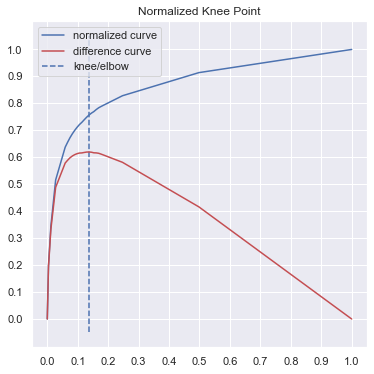

In [209]:
kneedle = KneeLocator(JK,  #x values
                      distortions_all, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
kneedle.plot_knee_normalized()
print(kneedle.elbow)
print(kneedle.elbow_y)

In [81]:

distortions2 = []
k = 2 
K=[]
while k <= 512:
    K.append(k)
    kmeanModel2 = KMeans(n_clusters=k)
    kmeanModel2.fit(X_seqvec_ep)
    distortions2.append(kmeanModel2.inertia_)
    print(k, kmeanModel2.inertia_)
    k *= 2
    

2 151988.40684323318
4 130485.70487400822
8 113162.25285379519
16 99438.03111038252
32 86192.68923297233
64 74222.12668135515
128 64022.64329962483
256 54512.87108877138
512 45507.20377232341


In [210]:
distortions_plus2 = []
k = 64 - 32
J=[]
while k <= 64+32:
    J.append(k)
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_seqvec_ep)
    distortions_plus2.append(kmeanModel.inertia_)
    print(k, kmeanModel.inertia_)
    k += 8

JK = J + K
distortions_all2 = distortions_plus2 + distortions2 
sorted_index = sorted(range(len(JK)), key=lambda k: JK[k])
JK = [JK[i] for i in sorted_index]
distortions_all2 = [distortions_all2[i] for i in sorted_index]

32 86534.58327905256
40 81999.8720354935
48 78662.10285082615
56 76382.44828267436
64 74276.1265246744
72 72313.85809851218
80 70948.4854148146
88 69413.87963822458
96 68230.05607324833


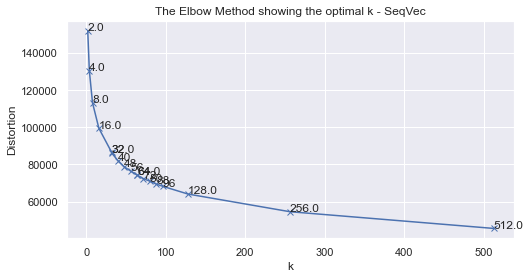

In [211]:
plt.figure(figsize=(8,4))
Y = distortions_all2
X = JK
plt.plot(X, Y, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k - SeqVec')

for i, label in enumerate(X):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

72.0
72313.85809851218


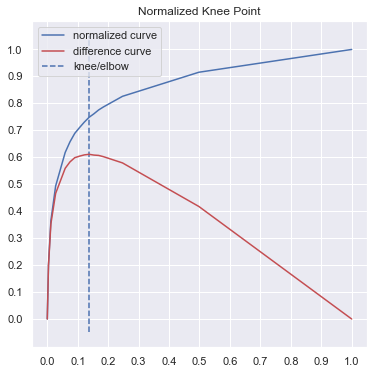

In [214]:
kneedle = KneeLocator(JK,  #x values
                      distortions_all2, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
kneedle.plot_knee_normalized()
print(kneedle.elbow)
print(kneedle.elbow_y)

64.0
74222.12668135515


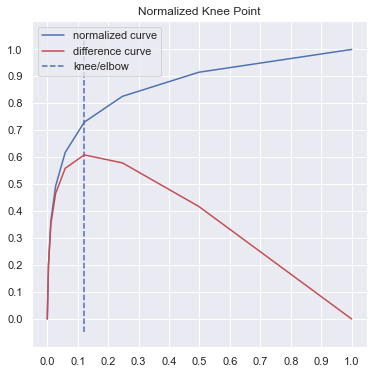

In [175]:
kneedle = KneeLocator(K,  #x values
                      distortions2, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
kneedle.plot_knee_normalized()
print(kneedle.elbow)
print(kneedle.elbow_y)

For SeqVec also around 64

2 4487.931452246327
4 3717.7533590951466
8 2898.1566341556977
16 2386.9875829189286
32 2012.3029561112432
64 1739.0949819951113
128 1520.040914571545
256 1338.9374684768316
512 1178.2500703994074


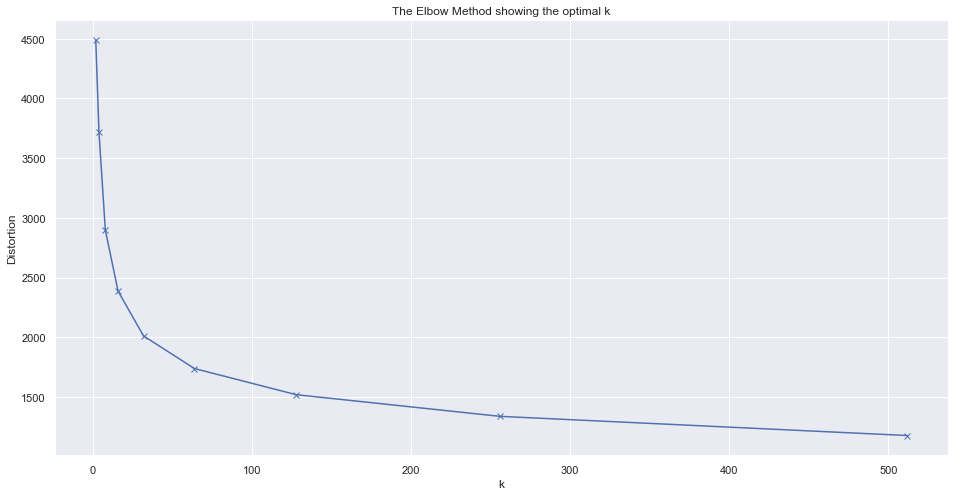

In [220]:

distortions3 = []
k = 2 
K=[]
while k <= 512:
    K.append(k)
    kmeanModel3 = KMeans(n_clusters=k)
    kmeanModel3.fit(X_curvenet_ep)
    distortions3.append(kmeanModel3.inertia_)
    print(k, kmeanModel3.inertia_)
    k *= 2
    
    
plt.figure(figsize=(16,8))
plt.plot(K[:len(distortions3)], distortions3, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [221]:
distortions_plus3 = []
k = 64 - 32
J=[]
while k <= 64+32:
    J.append(k)
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_curvenet_ep)
    distortions_plus3.append(kmeanModel.inertia_)
    print(k, kmeanModel.inertia_)
    k += 8

JK = J + K
distortions_all3 = distortions_plus3 + distortions3
sorted_index = sorted(range(len(JK)), key=lambda k: JK[k])
JK = [JK[i] for i in sorted_index]
distortions_all3 = [distortions_all3[i] for i in sorted_index]

32 2008.8027119692913
40 1914.2585750682324
48 1844.3760581015517
56 1787.2341905378848
64 1740.4467870709198
72 1701.1399017417525
80 1665.4989063344951
88 1634.4185979074975
96 1607.7468059084438


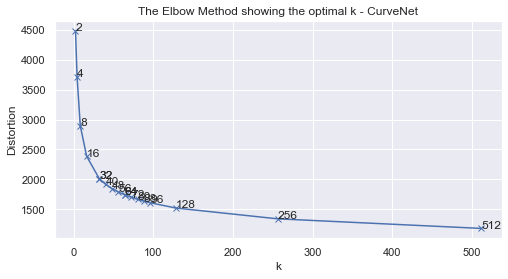

In [222]:
plt.figure(figsize=(8,4))
Y = distortions_all3
X = JK
plt.plot(X, Y, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k - CurveNet')

for i, label in enumerate(X):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

64
1740.4467870709198


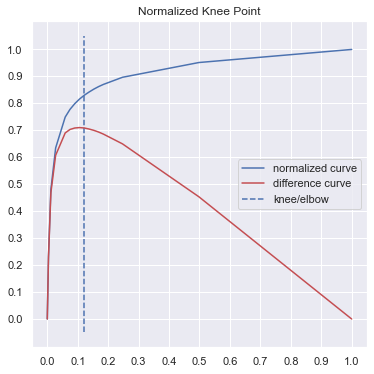

In [223]:
kneedle = KneeLocator(JK,  #x values
                      distortions_all3, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
kneedle.plot_knee_normalized()
print(kneedle.elbow)
print(kneedle.elbow_y)


## A. DBSCAN


Find the optimal epsilon using the approach outlined here: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

### Find Optimal eps 

In [309]:
def find_elbow(n_neighbors, 
               X_embed, 
               curve='convex',   # convex or concave 
               direction="decreasing"   # increasing or decreasing
              ):
    beg = datetime.datetime.now()
    ts = beg.strftime("%Y-%m-%d-%H:%M")
    print("###############")
    print(ts)

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)
    distance_desc = sorted(distances[:,-1])
#     distance_desc = sorted(distances[:,-1], reverse=True)
    plt.plot(distance_desc)
    plt.show()

    kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                          distance_desc, # y values
                          S=1.0, #parameter suggested from paper
                          curve=curve, #parameter from figure
                          direction=direction, #parameter from figure
                          online=True
                         )

    kneedle.plot_knee_normalized()
    plt.show()
    
    print("Run time:",  datetime.datetime.now() - beg )
    print()
    print("n_neighbors = {}".format(n_neighbors))
    print("Elbow:", kneedle.elbow)
    print("Elbow Y:", kneedle.elbow_y)
    
    return kneedle.elbow, kneedle.elbow_y

#### deepfold

###############
2021-11-20-22:28


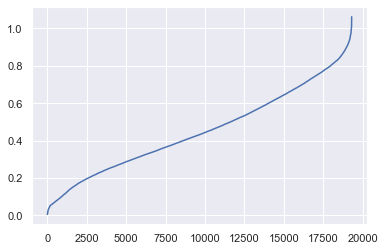

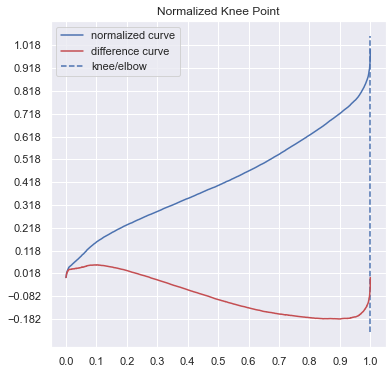

Run time: 0:00:10.278663

n_neighbors = 5
Elbow: 19275
Elbow Y: 0.9897801536549776
###############
2021-11-20-22:29


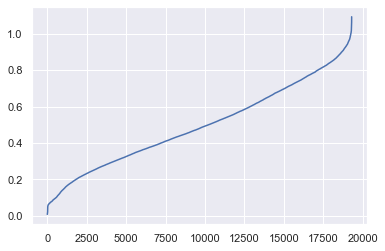

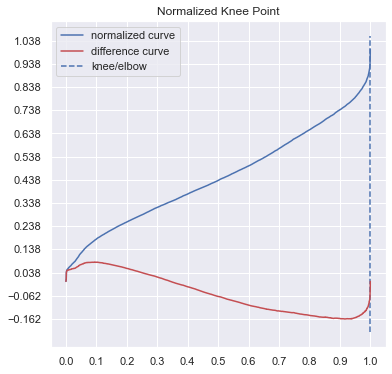

Run time: 0:00:10.320117

n_neighbors = 10
Elbow: 19289
Elbow Y: 1.034100066304239
###############
2021-11-20-22:29


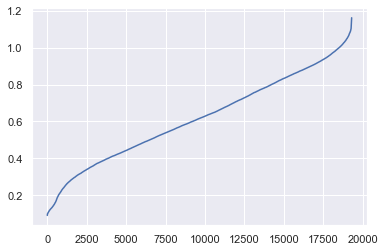

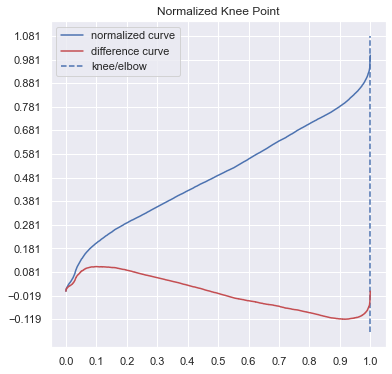

Run time: 0:00:10.402869

n_neighbors = 100
Elbow: 19275
Elbow Y: 1.1185423577243852
###############
2021-11-20-22:29


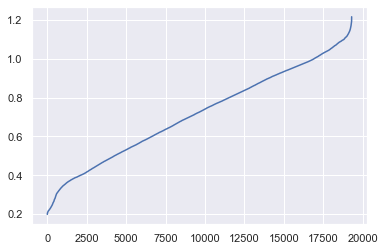

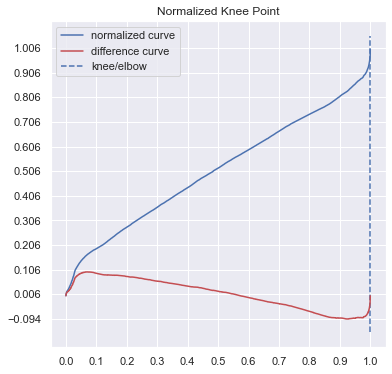

Run time: 0:00:11.163789

n_neighbors = 400
Elbow: 19285
Elbow Y: 1.1857293441133734
###############
2021-11-20-22:29


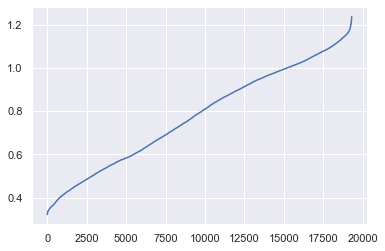

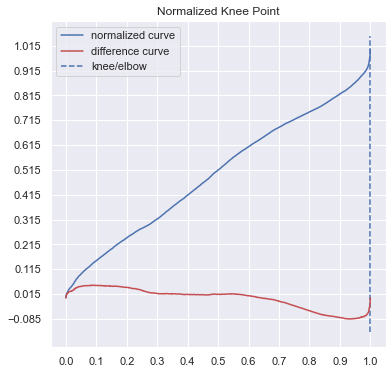

Run time: 0:00:11.661389

n_neighbors = 800
Elbow: 19272
Elbow Y: 1.206172077497645


In [297]:
eps_vals = []
n_neighbors = [5, 10, 100, 400, 800] 
for n_neigh in n_neighbors:
    elbow, elbow_y = find_elbow(n_neighbors=n_neigh, 
                            X_embed=X_deepfold_ep,
                               curve='concave',
                               direction='increasing')
    eps_vals.append(elbow_y)
    

In [298]:
input_est_deepfold = pd.DataFrame(data=[n_neighbors, eps_vals],
                                  ).transpose()
input_est_deepfold.columns=["n_neighbors", "eps"]
input_est_deepfold

,n_neighbors,eps
0,5.0,0.989780
1,10.0,1.034100
2,100.0,1.118542
3,400.0,1.185729
4,800.0,1.206172


#### seqvec

###############
2021-11-20-22:52


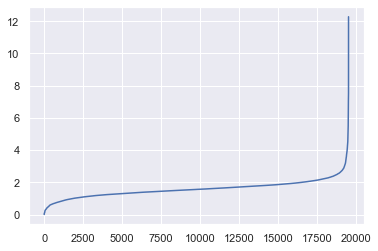

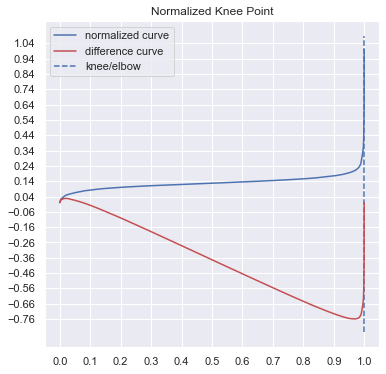

Run time: 0:00:13.328002

n_neighbors = 5
Elbow: 19508
Elbow Y: 7.145089998238848
###############
2021-11-20-22:52


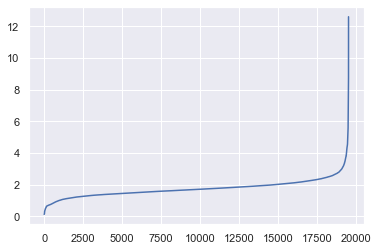

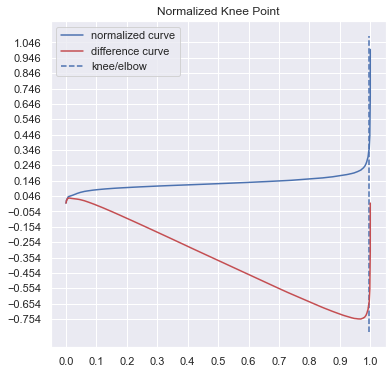

Run time: 0:00:13.449211

n_neighbors = 10
Elbow: 19462
Elbow Y: 4.870093404641362
###############
2021-11-20-22:53


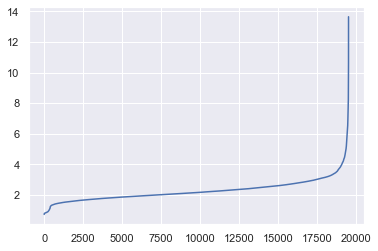

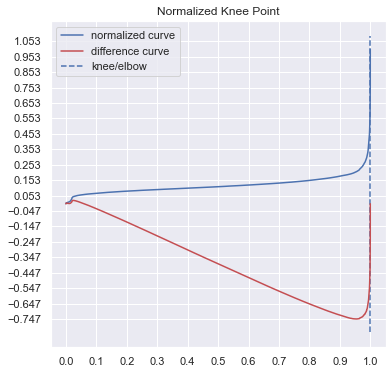

Run time: 0:00:13.599901

n_neighbors = 100
Elbow: 19482
Elbow Y: 7.334979182781726
###############
2021-11-20-22:53


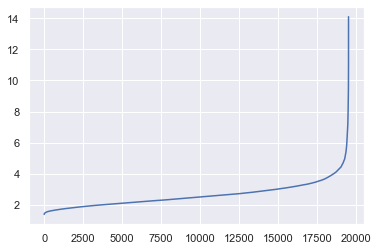

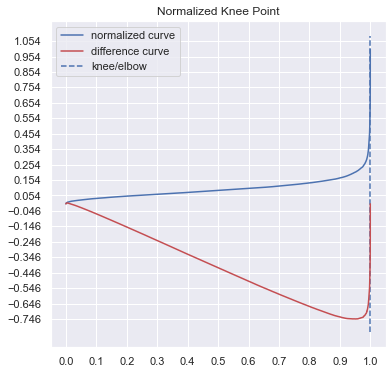

Run time: 0:00:14.410591

n_neighbors = 400
Elbow: 19468
Elbow Y: 7.06756880415041
###############
2021-11-20-22:53


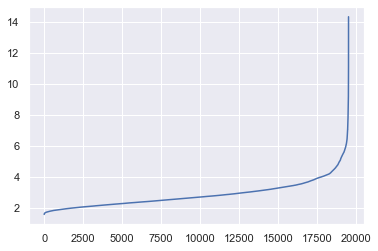

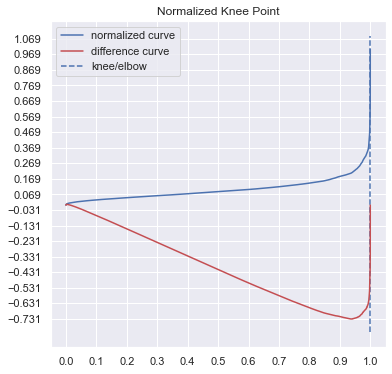

Run time: 0:00:15.475420

n_neighbors = 800
Elbow: 19466
Elbow Y: 7.232360874006589


In [310]:
eps_vals = []
n_neighbors = [5, 10, 100, 400, 800] 
for n_neigh in n_neighbors:
    elbow, elbow_y = find_elbow(n_neighbors=n_neigh, 
                               X_embed=X_seqvec_ep,
                               curve='concave',
                               direction='increasing')
    eps_vals.append(elbow_y)
    

In [311]:
input_est_seqvec = pd.DataFrame(data=[n_neighbors, eps_vals],
                                  ).transpose()
input_est_seqvec.columns=["n_neighbors", "eps"]
input_est_seqvec

,n_neighbors,eps
0,5.0,7.145090
1,10.0,4.870093
2,100.0,7.334979
3,400.0,7.067569
4,800.0,7.232361


#### curvenet

###############
2021-11-20-22:53


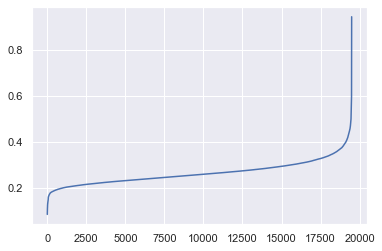

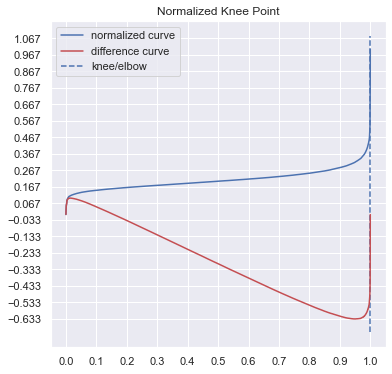

Run time: 0:00:14.530385

n_neighbors = 5
Elbow: 19445
Elbow Y: 0.49683672714999494
###############
2021-11-20-22:54


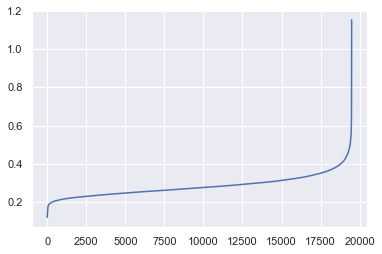

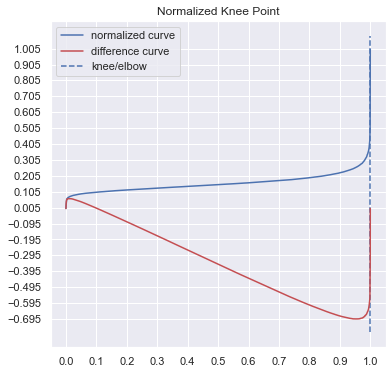

Run time: 0:00:14.261991

n_neighbors = 10
Elbow: 19463
Elbow Y: 0.5681916300066234
###############
2021-11-20-22:54


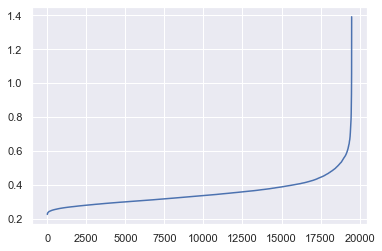

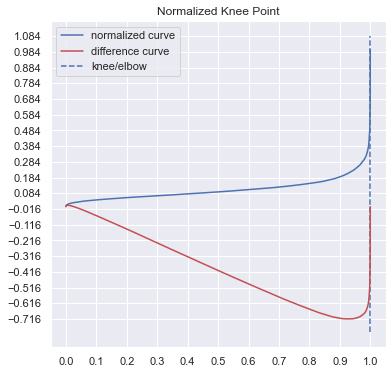

Run time: 0:00:14.116092

n_neighbors = 100
Elbow: 19466
Elbow Y: 0.8682669674769076
###############
2021-11-20-22:54


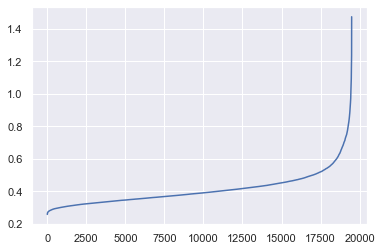

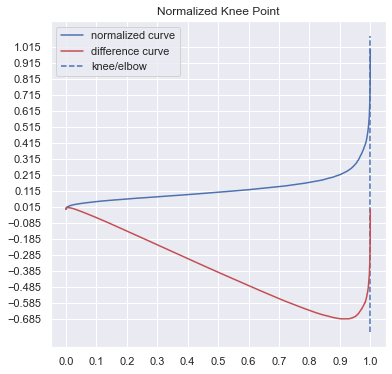

Run time: 0:00:14.987505

n_neighbors = 400
Elbow: 19449
Elbow Y: 1.0318416542219953
###############
2021-11-20-22:54


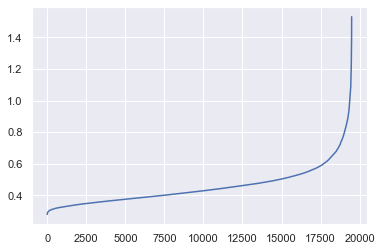

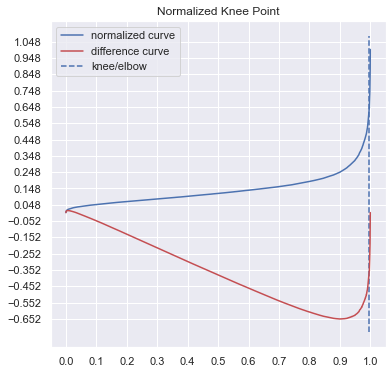

Run time: 0:00:16.397904

n_neighbors = 800
Elbow: 19380
Elbow Y: 1.0116116068325962


In [312]:
eps_vals = []
n_neighbors = [5, 10, 100, 400, 800] 
for n_neigh in n_neighbors:
    elbow, elbow_y = find_elbow(n_neighbors=n_neigh, 
                                X_embed=X_curvenet_ep,
                               curve='concave',
                               direction='increasing')
    eps_vals.append(elbow_y)

In [313]:
input_est_curvenet = pd.DataFrame(data=[n_neighbors, eps_vals],
                                  ).transpose()
input_est_curvenet.columns=["n_neighbors", "eps"]
input_est_curvenet

,n_neighbors,eps
0,5.0,0.496837
1,10.0,0.568192
2,100.0,0.868267
3,400.0,1.031842
4,800.0,1.011612



### A.1.EP DBSCAN + DeepFold excluding proteins with plDDT <50

The elbow method suggests that I use eps = 0.89. The min_samples will need to depend on the intuition and domain knowledge. Given that if we were to do K means, the elbow method suggested K = 72, and we have 20,000 proteins, I would guess `20000/72 = 277` so an average of 277 samples per cluster is expected.

#### Guess + Euclidean

In [177]:
range_eps = np.linspace(start=0.1, stop=1.4, num=6)
range_min_samples = [2, 5, 10]

a1_gridsearch = ev.dbscan_gridsearch(X_deepfold_ep, range_eps, range_min_samples, metric='euclidean')

0.1 2
0.1 5
0.1 10
0.36 2
0.36 5
0.36 10
0.6199999999999999 2
0.6199999999999999 5
0.6199999999999999 10
0.8799999999999998 2
0.8799999999999998 5
0.8799999999999998 10
1.14 2
1.14 5
1.14 10
1.4 2
1.4 5
1.4 10


In [178]:
a1_gridsearch[
    (a1_gridsearch["Noise Size"] > 0)
    & (a1_gridsearch["Num. Clusters"] > 100)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
6,0.62,2,euclidean,593,2610,15346,1.355311,-0.131881,1.103202,-0.110608
3,0.36,2,euclidean,1203,8684,7433,1.221966,-0.238412,1.044844,-0.119199
4,0.36,5,euclidean,137,11422,7300,1.281423,-0.264797,1.060325,-0.202788
0,0.10,2,euclidean,626,17810,293,0.975601,-0.352351,0.320525,0.577396


None of these models look usable because either there's too much noise or too much concentration in one giant cluster. The best it can do is 8684 in noise plus 7433 in a big cluster, at a total of about 16,000 untrustworthy protein clustering.

#### Elbow + Euclidean

In [246]:
range_eps         = input_est_deepfold.eps
range_min_samples = input_est_deepfold.n_neighbors

a1_gridsearch = ev.dbscan_gridsearch(X_deepfold_ep, 
                                     range_eps, 
                                     range_min_samples, 
                                     metric='euclidean')

0.9096218864326864 5.0
0.9096218864326864 10.0
0.9096218864326864 100.0
0.9096218864326864 400.0
0.9096218864326864 800.0
1.0341562478506807 5.0
1.0341562478506807 10.0
1.0341562478506807 100.0
1.0341562478506807 400.0
1.0341562478506807 800.0
1.0880393339399042 5.0
1.0880393339399042 10.0
1.0880393339399042 100.0
1.0880393339399042 400.0
1.0880393339399042 800.0
1.1386350895585926 5.0
1.1386350895585926 10.0
1.1386350895585926 100.0
1.1386350895585926 400.0
1.1386350895585926 800.0
1.1813079757018667 5.0
1.1813079757018667 10.0
1.1813079757018667 100.0
1.1813079757018667 400.0
1.1813079757018667 800.0


In [251]:
a1_gridsearch[
    (a1_gridsearch["Noise Size"] > 0)
    & (a1_gridsearch["Num. Clusters"] > 10)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise


In [252]:
a1_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
12,1.088039,100.0,euclidean,0,0,None,None,None,None,None
22,1.181308,100.0,euclidean,0,0,None,None,None,None,None
21,1.181308,10.0,euclidean,0,0,None,None,None,None,None
20,1.181308,5.0,euclidean,0,0,None,None,None,None,None
19,1.138635,800.0,euclidean,0,0,None,None,None,None,None
18,1.138635,400.0,euclidean,0,0,None,None,None,None,None
17,1.138635,100.0,euclidean,0,0,None,None,None,None,None
16,1.138635,10.0,euclidean,0,0,None,None,None,None,None
15,1.138635,5.0,euclidean,0,0,None,None,None,None,None
14,1.088039,800.0,euclidean,0,0,None,None,None,None,None


In [253]:
a1ep_model = DBSCAN(eps=0.909622, 
                  min_samples=800,
                  metric='euclidean').fit(X_deepfold_ep)

In [261]:
np.unique(a1ep_model.labels_)

array([-1,  0])

#### Guess + Cosine

In [179]:
# With cosine 
range_eps = np.linspace(start=0.05, stop=0.9, num=5)
range_min_samples = [2, 5, 10]

a1_gridsearch  = ev.dbscan_gridsearch(X_deepfold_ep, range_eps, range_min_samples, metric='cosine')

0.05 2
0.05 5
0.05 10
0.2625 2
0.2625 5
0.2625 10
0.475 2
0.475 5
0.475 10
0.6875 2
0.6875 5
0.6875 10
0.9 2
0.9 5
0.9 10


In [190]:
a1_gridsearch[
    (a1_gridsearch["Noise Size"] > 0)
    & (a1_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
3,0.2625,2,cosine,282,1258,18076,1.404573,-0.093246,1.137328,-0.0843
4,0.2625,5,cosine,51,1932,17944,1.645877,-0.012078,1.248503,0.003874
0,0.0500,2,cosine,1222,10240,5451,1.187003,-0.239669,0.972835,-0.054089
1,0.0500,5,cosine,137,13038,5284,1.226663,-0.243661,0.979484,-0.097481


The least egregious seems to be the modein index `0`, despite a large number of clusters (1,223). But notice how the Silhouette score is negative. 

In [61]:
range_eps = np.linspace(start=0.1, stop=1.4, num=6)
range_min_samples = [2, 5, 10]

a1ep_gridsearch = ev.dbscan_gridsearch(X_deepfold_ep, range_eps, range_min_samples, metric='euclidean')

0.1 2
0.1 5
0.1 10
0.36 2
0.36 5
0.36 10
0.6199999999999999 2
0.6199999999999999 5
0.6199999999999999 10
0.8799999999999998 2
0.8799999999999998 5
0.8799999999999998 10
1.14 2
1.14 5
1.14 10
1.4 2
1.4 5
1.4 10


In [62]:
a1ep_gridsearch[
    (a1ep_gridsearch["Noise Size"] > 0)
    & (a1ep_gridsearch["Num. Clusters"] > 100)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
6,0.62,2,euclidean,565,2546,14539,1.354391,-0.130558,1.099627,-0.108678
3,0.36,2,euclidean,1119,8370,7033,1.222368,-0.241674,1.044288,-0.123061
4,0.36,5,euclidean,128,10935,6881,1.294789,-0.266514,1.062541,-0.206798
0,0.10,2,euclidean,577,16993,274,0.976238,-0.354153,0.325622,0.575464


Euclidean doesn't do so well.

In [63]:
# With cosine 
range_eps = np.linspace(start=0.05, stop=0.9, num=5)
range_min_samples = [2, 5, 10]

a1ep_gridsearch  = ev.dbscan_gridsearch(X_deepfold_ep, range_eps, range_min_samples, metric='cosine')

0.05 2
0.05 5
0.05 10
0.2625 2
0.2625 5
0.2625 10
0.475 2
0.475 5
0.475 10
0.6875 2
0.6875 5
0.6875 10
0.9 2
0.9 5
0.9 10


In [64]:
a1ep_gridsearch[
    (a1ep_gridsearch["Noise Size"] > 0)
    & (a1ep_gridsearch["Num. Clusters"] > 100)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
3,0.2625,2,cosine,272,1231,17142,1.415332,-0.09157,1.143928,-0.082341
0,0.0500,2,cosine,1131,9862,4930,1.184614,-0.236012,0.947429,-0.043564
1,0.0500,5,cosine,125,12453,4771,1.220268,-0.228092,0.949847,-0.06033


Similar to before, the least egregious seems to be the modein index `0`, despite a large number of clusters. But notice how the Silhouette score is still negative. 

Noise: 9862 and max cluster: 4930 compared to  10240 + 5451 before. 

In [66]:
a1ep_model = DBSCAN(eps=0.0500, 
                  min_samples=2,
                  metric='cosine').fit(X_deepfold_ep)

In [67]:
file_path = 'model_outputs/a1ep_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(a1ep_model, file)

### A.2.EP DBSCAN + SeqVec excluding D conf proteins

#### Elbow + Euclidean

In [317]:
range_eps         = input_est_seqvec.eps
range_min_samples = input_est_seqvec.n_neighbors

a2ep_gridsearch = ev.dbscan_gridsearch(X_seqvec_ep, 
                                     range_eps, 
                                     range_min_samples, 
                                     metric='euclidean')

7.145089998238848 5.0
7.145089998238848 10.0
7.145089998238848 100.0
7.145089998238848 400.0
7.145089998238848 800.0
4.870093404641362 5.0
4.870093404641362 10.0
4.870093404641362 100.0
4.870093404641362 400.0
4.870093404641362 800.0
7.334979182781726 5.0
7.334979182781726 10.0
7.334979182781726 100.0
7.334979182781726 400.0
7.334979182781726 800.0
7.06756880415041 5.0
7.06756880415041 10.0
7.06756880415041 100.0
7.06756880415041 400.0
7.06756880415041 800.0
7.232360874006589 5.0
7.232360874006589 10.0
7.232360874006589 100.0
7.232360874006589 400.0
7.232360874006589 800.0


In [318]:
a2ep_gridsearch[
    (a2ep_gridsearch["Noise Size"] > 0)
    & (a2ep_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise


In [319]:
a2ep_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,7.145090,5.0,euclidean,1,1,None,None,None,None,None
21,7.232361,10.0,euclidean,1,1,None,None,None,None,None
20,7.232361,5.0,euclidean,1,1,None,None,None,None,None
11,7.334979,10.0,euclidean,1,1,None,None,None,None,None
10,7.334979,5.0,euclidean,1,1,None,None,None,None,None
1,7.145090,10.0,euclidean,1,2,None,None,None,None,None
15,7.067569,5.0,euclidean,1,2,None,None,None,None,None
22,7.232361,100.0,euclidean,1,3,None,None,None,None,None
14,7.334979,800.0,euclidean,1,3,None,None,None,None,None
13,7.334979,400.0,euclidean,1,3,None,None,None,None,None


#### Guess + Cosine

In [68]:
# With cosine 
range_eps = np.linspace(start=0.05, stop=0.9, num=5)
range_min_samples = [1, 2, 5, 10]

a2ep_gridsearch  = ev.dbscan_gridsearch(X_seqvec_ep, range_eps, range_min_samples, metric='cosine')

0.05 1
0.05 2
0.05 5
0.05 10
0.2625 1
0.2625 2
0.2625 5
0.2625 10
0.475 1
0.475 2
0.475 5
0.475 10
0.6875 1
0.6875 2
0.6875 5
0.6875 10
0.9 1
0.9 2
0.9 5
0.9 10


In [69]:
a2ep_gridsearch[
    (a2ep_gridsearch["Noise Size"] > 0)
    & (a2ep_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
1,0.05,2,cosine,1534,12293,691,1.216958,-0.158202,0.752045,0.367753
2,0.05,5,cosine,209,15570,689,1.210666,-0.20539,0.825885,0.407316
3,0.05,10,cosine,74,16747,686,1.150026,-0.179953,0.806737,0.447147


The least aggregious seems to be index 1. That's the same set of params as model a1 with a different embedding. This noise level is way too high.

In [320]:
# With cosine 
range_eps = np.linspace(start=1, stop=3.5, num=5)
range_min_samples = [1, 2, 5, 10]

a2ep_gridsearch  = ev.dbscan_gridsearch(X_seqvec_ep, range_eps, range_min_samples, metric='cosine')

1.0 1
1.0 2
1.0 5
1.0 10
1.625 1
1.625 2
1.625 5
1.625 10
2.25 1
2.25 2
2.25 5
2.25 10
2.875 1
2.875 2
2.875 5
2.875 10
3.5 1
3.5 2
3.5 5
3.5 10


In [321]:
a2ep_gridsearch[
    (a2ep_gridsearch["Noise Size"] > 0)
    & (a2ep_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise


In [322]:
a2ep_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,1.000,1,cosine,0,0,None,None,None,None,None
17,3.500,2,cosine,0,0,None,None,None,None,None
16,3.500,1,cosine,0,0,None,None,None,None,None
15,2.875,10,cosine,0,0,None,None,None,None,None
14,2.875,5,cosine,0,0,None,None,None,None,None
13,2.875,2,cosine,0,0,None,None,None,None,None
12,2.875,1,cosine,0,0,None,None,None,None,None
11,2.250,10,cosine,0,0,None,None,None,None,None
10,2.250,5,cosine,0,0,None,None,None,None,None
9,2.250,2,cosine,0,0,None,None,None,None,None


In [70]:
a2ep_model = DBSCAN(eps=0.0500, 
                  min_samples=2,
                  metric='cosine').fit(X_seqvec_ep)

### A.3 DBSCAN + CurveNet

#### Guess + Cosine

In [8]:
# With cosine 
range_eps = np.linspace(start=0.005, stop=0.05, num=5)
range_min_samples = [1, 2, 5, 10]

a3_gridsearch  = ev.dbscan_gridsearch(X_curvenet, range_eps, range_min_samples, metric='cosine')

0.005 1
0.005 2
0.005 5
0.005 10
0.01625 1
0.01625 2
0.01625 5
0.01625 10
0.027500000000000004 1
0.027500000000000004 2
0.027500000000000004 5
0.027500000000000004 10
0.03875 1
0.03875 2
0.03875 5
0.03875 10
0.05 1
0.05 2
0.05 5
0.05 10


In [9]:
a3_gridsearch[
    (a3_gridsearch["Noise Size"] > 0)
    & (a3_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
1,0.005,2,cosine,579,16966,863,1.388105,-0.430731,1.074002,0.058811


In [10]:
a3_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,0.00500,1,cosine,17544,0,863,0.565252,-0.014355,0.565252,-0.014355
16,0.05000,1,cosine,10,0,20390,0.490856,0.291468,0.490856,0.291468
4,0.01625,1,cosine,538,0,19801,0.694465,-0.294993,0.694465,-0.294993
12,0.03875,1,cosine,17,0,20383,0.448104,0.269940,0.448104,0.269940
8,0.02750,1,cosine,59,0,20328,0.558619,0.022859,0.558619,0.022859
17,0.05000,2,cosine,4,7,20390,1.274202,0.404433,0.579993,0.414103
18,0.05000,5,cosine,2,13,20390,1.220754,0.491032,0.278555,0.616947
13,0.03875,2,cosine,4,14,20383,1.263734,0.419336,0.464834,0.456645
19,0.05000,10,cosine,2,21,20382,1.335765,0.503082,0.278274,0.617503
14,0.03875,5,cosine,3,22,20375,1.311175,0.459249,0.479750,0.504266


#### Guess + Euclidean

In [14]:
# With euclidean
range_eps = np.linspace(start=0.005, stop=0.05, num=5)
range_min_samples = [1, 2, 5, 10]

a3_gridsearch  = ev.dbscan_gridsearch(X_curvenet, range_eps, range_min_samples, metric='euclidean')

0.005 1
0.005 2
0.005 5
0.005 10
0.01625 1
0.01625 2
0.01625 5
0.01625 10
0.027500000000000004 1
0.027500000000000004 2
0.027500000000000004 5
0.027500000000000004 10
0.03875 1
0.03875 2
0.03875 5
0.03875 10
0.05 1
0.05 2
0.05 5
0.05 10


In [15]:
a3_gridsearch[
    (a3_gridsearch["Noise Size"] > 0)
    & (a3_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise


In [16]:
a3_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,0.00500,1,euclidean,20403,0,1,0.0,0.00376,0.0,0.00376
16,0.05000,1,euclidean,20402,0,2,0.039059,0.00379,0.039059,0.00379
4,0.01625,1,euclidean,20403,0,1,0.0,0.00376,0.0,0.00376
12,0.03875,1,euclidean,20403,0,1,0.0,0.00376,0.0,0.00376
8,0.02750,1,euclidean,20403,0,1,0.0,0.00376,0.0,0.00376
17,0.05000,2,euclidean,2,20401,77,1.034866,-0.121745,0.013165,0.999333
15,0.03875,10,euclidean,1,20403,None,None,None,None,None
14,0.03875,5,euclidean,1,20403,None,None,None,None,None
13,0.03875,2,euclidean,1,20403,None,None,None,None,None
11,0.02750,10,euclidean,1,20403,None,None,None,None,None


In [20]:
# With euclidean
range_eps = np.linspace(start=0.75, stop=1.25, num=5)
range_min_samples = [5, 10]

a3_gridsearch  = ev.dbscan_gridsearch(X_curvenet, range_eps, range_min_samples, metric='euclidean')

0.75 5
0.75 10
0.875 5
0.875 10
1.0 5
1.0 10
1.125 5
1.125 10
1.25 5
1.25 10


In [22]:
a3_gridsearch[
    (a3_gridsearch["Noise Size"] > 0)
    & (a3_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise


In [23]:
a3_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
4,1.000,5,euclidean,0,0,None,None,None,None,None
5,1.000,10,euclidean,0,0,None,None,None,None,None
6,1.125,5,euclidean,0,0,None,None,None,None,None
7,1.125,10,euclidean,0,0,None,None,None,None,None
8,1.250,5,euclidean,0,0,None,None,None,None,None
9,1.250,10,euclidean,0,0,None,None,None,None,None
0,0.750,5,euclidean,1,1,None,None,None,None,None
2,0.875,5,euclidean,1,1,None,None,None,None,None
3,0.875,10,euclidean,1,1,None,None,None,None,None
1,0.750,10,euclidean,1,4,None,None,None,None,None


#### Elbow + Euclidean

In [314]:
### from elbow 
range_eps         = input_est_curvenet.eps
range_min_samples = input_est_curvenet.n_neighbors

a3ep_gridsearch = ev.dbscan_gridsearch(X_curvenet_ep, 
                                     range_eps, 
                                     range_min_samples, 
                                     metric='euclidean')

0.49683672714999494 5.0
0.49683672714999494 10.0
0.49683672714999494 100.0
0.49683672714999494 400.0
0.49683672714999494 800.0
0.5681916300066234 5.0
0.5681916300066234 10.0
0.5681916300066234 100.0
0.5681916300066234 400.0
0.5681916300066234 800.0
0.8682669674769076 5.0
0.8682669674769076 10.0
0.8682669674769076 100.0
0.8682669674769076 400.0
0.8682669674769076 800.0
1.0318416542219953 5.0
1.0318416542219953 10.0
1.0318416542219953 100.0
1.0318416542219953 400.0
1.0318416542219953 800.0
1.0116116068325962 5.0
1.0116116068325962 10.0
1.0116116068325962 100.0
1.0116116068325962 400.0
1.0116116068325962 800.0


In [315]:
a3ep_gridsearch[
    (a3ep_gridsearch["Noise Size"] > 0)
    & (a3ep_gridsearch["Num. Clusters"] > 50)
]

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise


In [316]:
a3ep_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
24,1.011612,800.0,euclidean,0,0,None,None,None,None,None
22,1.011612,100.0,euclidean,0,0,None,None,None,None,None
21,1.011612,10.0,euclidean,0,0,None,None,None,None,None
20,1.011612,5.0,euclidean,0,0,None,None,None,None,None
19,1.031842,800.0,euclidean,0,0,None,None,None,None,None
18,1.031842,400.0,euclidean,0,0,None,None,None,None,None
17,1.031842,100.0,euclidean,0,0,None,None,None,None,None
16,1.031842,10.0,euclidean,0,0,None,None,None,None,None
15,1.031842,5.0,euclidean,0,0,None,None,None,None,None
10,0.868267,5.0,euclidean,0,0,None,None,None,None,None


In [ ]:
a3_model = DBSCAN(eps=0.0500, 
                  min_samples=2,
                  metric='cosine').fit(X_curvenet)

In [ ]:

file_path = 'model_outputs/a3_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(a3_model, file)

## B. HDBSCAN

### B.1.EP HDBSCAN + DeepFold Excluding Proteins with Low Conf

In [71]:
min_cluster_sizes = [5, 10]
min_samples = [1, 5]
cluster_selection_epsilons = [0, 1.1, 1.3] 

b1ep_gridsearch = ev.hdbscan_gridsearch(X_deepfold_ep, 
                                       min_cluster_sizes,
                                       min_samples,
                                       cluster_selection_epsilons
                                      )

In [111]:

results =b1ep_gridsearch[
    (b1ep_gridsearch["Noise Size"] > 0)
    & (b1ep_gridsearch["Num. Clusters"] > 50)
]

results[['min_cluster_size', 'min_sample', 'alpha',
       'metric', 'Num. Clusters', 'Noise Size', 'Max Cluster Size', 'DB_sc',
       'Silhouette_sc', 'DB_sc excl. noise', 'Silhouette_sc excl. noise']].drop_duplicates()

,min_cluster_size,min_sample,alpha,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,5,1,1.0,cosine,557,13544,288,1.404045,-0.221075,1.163672,0.326689
6,10,1,1.0,cosine,167,14352,641,1.435764,-0.199735,1.209652,0.319761
9,10,5,1.0,cosine,118,15153,630,1.292895,-0.196634,0.965223,0.395917
3,5,5,1.0,cosine,223,15342,312,1.261020,-0.243431,0.918043,0.402343


In [73]:
b1_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 1, 
                                     p=None)
b1_model.fit(X_deepfold_ep)

HDBSCAN(algorithm='generic', metric='cosine', min_samples=1)

In [112]:
b1epa_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 5, 
                                     p=None)
b1epa_model.fit(X_deepfold_ep)

HDBSCAN(algorithm='generic', metric='cosine', min_samples=5)

In [113]:
b1epb_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 10, 
                                     min_samples= 1, 
                                     p=None)
b1epb_model.fit(X_deepfold_ep)

HDBSCAN(algorithm='generic', metric='cosine', min_cluster_size=10,
        min_samples=1)

In [114]:
b1epc_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 10, 
                                     min_samples= 5, 
                                     p=None)
b1epc_model.fit(X_deepfold_ep)

HDBSCAN(algorithm='generic', metric='cosine', min_cluster_size=10,
        min_samples=5)

In [115]:

file_path = 'model_outputs/no_cluster_size_limit/otherparams/b1epa_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(b1epa_model, file)

In [116]:

file_path = 'model_outputs/no_cluster_size_limit/otherparams/b1epb_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(b1epb_model, file)

In [117]:

file_path = 'model_outputs/no_cluster_size_limit/otherparams/b1epc_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(b1epc_model, file)

### B.2.EP HDBSCAN + SeqVec excuding proteins with low conf

In [74]:
min_cluster_sizes = [5, 10]
min_samples = [1, 5]
cluster_selection_epsilons = [0, 0.2, 0.5, 1.0]

b2ep_gridsearch = ev.hdbscan_gridsearch(X_seqvec_ep, 
                                       min_cluster_sizes,
                                       min_samples,
                                       cluster_selection_epsilons
                                      )

In [94]:
results = b2ep_gridsearch[
    (b2ep_gridsearch["Noise Size"] > 0)
    & (b2ep_gridsearch["Num. Clusters"] > 50)
]

In [95]:
results.columns

Index(['min_cluster_size', 'min_sample', 'cluster_selection_epsilon', 'alpha',
       'metric', 'Num. Clusters', 'Noise Size', 'Max Cluster Size', 'DB_sc',
       'Silhouette_sc', 'DB_sc excl. noise', 'Silhouette_sc excl. noise'],
      dtype='object')

In [96]:
results[['min_cluster_size', 'min_sample', 'alpha',
       'metric', 'Num. Clusters', 'Noise Size', 'Max Cluster Size', 'DB_sc',
       'Silhouette_sc', 'DB_sc excl. noise', 'Silhouette_sc excl. noise']].drop_duplicates()

,min_cluster_size,min_sample,alpha,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,5,1,1.0,cosine,741,10840,416,1.601412,-0.132854,1.358248,0.233076
8,10,1,1.0,cosine,284,12003,416,1.662921,-0.125143,1.420978,0.244064
4,5,5,1.0,cosine,314,13462,401,1.406995,-0.155059,1.103777,0.323994
12,10,5,1.0,cosine,184,13854,446,1.436177,-0.130497,1.095737,0.333231


In [76]:
b2ep_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 1, 
                                     p=None)
b2ep_model.fit(X_seqvec_ep)

HDBSCAN(algorithm='generic', metric='cosine', min_samples=1)

In [97]:
b2epa_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 5, 
                                     p=None)
b2epa_model.fit(X_seqvec_ep)

HDBSCAN(algorithm='generic', metric='cosine', min_samples=5)

In [98]:
b2epb_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 10, 
                                     min_samples= 1, 
                                     p=None)
b2epb_model.fit(X_seqvec_ep)

HDBSCAN(algorithm='generic', metric='cosine', min_cluster_size=10,
        min_samples=1)

In [99]:
b2epc_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 10, 
                                     min_samples= 5, 
                                     p=None)
b2epc_model.fit(X_seqvec_ep)

HDBSCAN(algorithm='generic', metric='cosine', min_cluster_size=10,
        min_samples=5)

In [101]:

file_path = 'model_outputs/b2epa_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(b2epa_model, file)

In [100]:

file_path = 'model_outputs/b2epc_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(b2epc_model, file)

In [102]:

file_path = 'model_outputs/b2epb_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(b2epb_model, file)

### B.3 HDBSCAN  + CurveNet

In [12]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [13]:
min_cluster_sizes = [5, 10]
min_samples = [1, 5]
cluster_selection_epsilons = [0, 0.2, 0.5, 1.0]

b3_gridsearch = ev.hdbscan_gridsearch(X_curvenet, 
                                       min_cluster_sizes,
                                       min_samples,
                                       cluster_selection_epsilons
                                      )

In [14]:
results = b3_gridsearch[
    (b3_gridsearch["Noise Size"] > 0)
    & (b3_gridsearch["Num. Clusters"] > 50)
]

In [15]:
results.columns

Index(['min_cluster_size', 'min_sample', 'cluster_selection_epsilon', 'alpha',
       'metric', 'Num. Clusters', 'Noise Size', 'Max Cluster Size', 'DB_sc',
       'Silhouette_sc', 'DB_sc excl. noise', 'Silhouette_sc excl. noise'],
      dtype='object')

In [17]:
results[['min_cluster_size', 'min_sample', 'alpha',
       'metric', 'Num. Clusters', 'Noise Size', 'Max Cluster Size', 'DB_sc',
       'Silhouette_sc', 'DB_sc excl. noise', 'Silhouette_sc excl. noise']].drop_duplicates()

,min_cluster_size,min_sample,alpha,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise


In [18]:
b3_gridsearch

,min_cluster_size,min_sample,cluster_selection_epsilon,alpha,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,5,1,0,1.0,cosine,1,0,20403,NaN,NaN,NaN,NaN
1,5,1,0.2,1.0,cosine,1,0,20403,NaN,NaN,NaN,NaN
2,5,1,0.5,1.0,cosine,1,0,20403,NaN,NaN,NaN,NaN
3,5,1,1.0,1.0,cosine,1,0,20403,NaN,NaN,NaN,NaN
8,10,1,0,1.0,cosine,1,0,20403,None,None,None,None
9,10,1,0.2,1.0,cosine,1,0,20403,None,None,None,None
10,10,1,0.5,1.0,cosine,1,0,20403,None,None,None,None
11,10,1,1.0,1.0,cosine,1,0,20403,None,None,None,None
4,5,5,0,1.0,cosine,2,1,20402,0.333766,0.517037,0.27888,0.616501
5,5,5,0.2,1.0,cosine,2,1,20402,0.333766,0.517037,0.27888,0.616501


In [ ]:
b3_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 1, 
                                     p=None)
b3_model.fit(X_curvenet)

In [ ]:

file_path = 'model_outputs/b3_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(b3_model, file)

# Evaluation


In [80]:
prefix = 'annotations/'
keys = gcs.list_file_paths(prefix)[1:]
keys

['gs://capstone-fall21-protein/annotations/blast_annotations.parquet',
 'gs://capstone-fall21-protein/annotations/blast_annotations_agg.parquet',
 'gs://capstone-fall21-protein/annotations/pairwise_evaluation_metrics.parquet']

In [81]:
# Download lookup files
pairwise_metrics = gcs.download_parquet("annotations/blast_annotations_agg.parquet")
# pairwise_metrics = pairwise_metrics.drop_duplicates()

# Download protein files, then summarizes amino acid sequence-level confidence information.
asp = ev.download_asp()

# Download sequences info 
sequences = gcs.download_parquet("structure_files/sequences/sequences.parquet")
sequences["seq_len"] = sequences["pdbx_seq_one_letter_code"].str.len()

In [82]:
pairwise_metrics.shape

(1963860, 5)

In [83]:
pairwise_metrics[0:10]

,query_protein,target_protein,hit_span_mean,bitscore_mean,evalue_mean
0,AF-A0A024R1R8-F1-model_v1,AF-P61978-F1-model_v1,41.0,23.9,9.500000e+00
1,AF-A0A024R1R8-F1-model_v1,AF-P98177-F1-model_v1,55.0,31.2,3.000000e-02
2,AF-A0A024R1R8-F1-model_v1,AF-Q7Z392-F1-model_v1,31.0,24.3,9.600000e+00
3,AF-A0A024R1R8-F1-model_v1,AF-Q8N2Y8-F1-model_v1,33.0,25.0,3.900000e+00
4,AF-A0A024R1R8-F1-model_v1,AF-Q969I3-F1-model_v1,36.0,24.3,6.800000e+00
5,AF-A0A024R1R8-F1-model_v1,AF-Q96CB9-F1-model_v1,33.0,29.3,1.500000e-01
6,AF-A0A024R1R8-F1-model_v1,AF-Q96ME7-F1-model_v1,52.0,24.3,8.900000e+00
7,AF-A0A024R1R8-F1-model_v1,AF-Q9H7D0-F1-model_v1,44.0,30.4,4.500000e-02
8,AF-A0A024R1R8-F1-model_v1,AF-Q9UPA5-F1-model_v1,63.0,26.2,1.700000e+00
9,AF-A0A024R1R8-F1-model_v1,AF-Q9Y2S6-F1-model_v1,64.0,57.4,3.770000e-13


In [84]:
pairwise_metrics["query_protein_orig"]=pairwise_metrics.query_protein
pairwise_metrics["target_protein_orig"]=pairwise_metrics.target_protein

pairwise_metrics["target_protein"]=pairwise_metrics.target_protein_orig.str.split('-', expand=True)[1]
pairwise_metrics["query_protein"]=pairwise_metrics.query_protein_orig.str.split('-', expand=True)[1]

In [85]:
pairwise_metrics[0:10]

,query_protein,target_protein,hit_span_mean,bitscore_mean,evalue_mean,query_protein_orig,target_protein_orig
0,A0A024R1R8,P61978,41.0,23.9,9.500000e+00,AF-A0A024R1R8-F1-model_v1,AF-P61978-F1-model_v1
1,A0A024R1R8,P98177,55.0,31.2,3.000000e-02,AF-A0A024R1R8-F1-model_v1,AF-P98177-F1-model_v1
2,A0A024R1R8,Q7Z392,31.0,24.3,9.600000e+00,AF-A0A024R1R8-F1-model_v1,AF-Q7Z392-F1-model_v1
3,A0A024R1R8,Q8N2Y8,33.0,25.0,3.900000e+00,AF-A0A024R1R8-F1-model_v1,AF-Q8N2Y8-F1-model_v1
4,A0A024R1R8,Q969I3,36.0,24.3,6.800000e+00,AF-A0A024R1R8-F1-model_v1,AF-Q969I3-F1-model_v1
5,A0A024R1R8,Q96CB9,33.0,29.3,1.500000e-01,AF-A0A024R1R8-F1-model_v1,AF-Q96CB9-F1-model_v1
6,A0A024R1R8,Q96ME7,52.0,24.3,8.900000e+00,AF-A0A024R1R8-F1-model_v1,AF-Q96ME7-F1-model_v1
7,A0A024R1R8,Q9H7D0,44.0,30.4,4.500000e-02,AF-A0A024R1R8-F1-model_v1,AF-Q9H7D0-F1-model_v1
8,A0A024R1R8,Q9UPA5,63.0,26.2,1.700000e+00,AF-A0A024R1R8-F1-model_v1,AF-Q9UPA5-F1-model_v1
9,A0A024R1R8,Q9Y2S6,64.0,57.4,3.770000e-13,AF-A0A024R1R8-F1-model_v1,AF-Q9Y2S6-F1-model_v1


In [86]:
pairwise_metrics.rename(
    columns={"bitscore_mean": "bitscore", 
             "evalue_mean": "evalue",
             'hit_span_mean':"hit_span"},
    inplace=True)

In [87]:
pairwise_metrics.columns

Index(['query_protein', 'target_protein', 'hit_span', 'bitscore', 'evalue',
       'query_protein_orig', 'target_protein_orig'],
      dtype='object')

In [88]:
pairwise_metrics[["target_protein", "query_protein"]].drop_duplicates().shape

(1963860, 2)

In [79]:
total_noise_stats = pd.DataFrame()
prefix = 'model_outputs/no_cluster_size_limit/otherparams/'


models = {
#           'A1': ('DBSCAN' , 'DeepFold', a1_model, protein_id_deepfold, X_deepfold),
#           'A2': ('DBSCAN' , 'SeqVec',   a2_model, protein_id_seqvec, X_seqvec),
#           'B1': ('HDBSCAN', 'DeepFold', b1_model, protein_id_deepfold, X_deepfold),
#           'B2': ('HDBSCAN', 'SeqVec',   b2_model, protein_id_seqvec, X_seqvec),
#           'A3': ('DBSCAN' , 'DeepFold_mask', a3_model, protein_id_deepfold_mask, X_deepfold_mask),
#           'B3': ('HDBSCAN', 'DeepFold_mask', b3_model, protein_id_deepfold_mask, X_deepfold_mask),
            
          'A1EP': ('DBSCAN' , 'DeepFold_EP', a1ep_model, protein_id_deepfold_ep, X_deepfold_ep),
          'A2EP': ('DBSCAN' , 'SeqVec_EP',   a2ep_model, protein_id_seqvec_ep, X_seqvec_ep),
          'B1EP': ('HDBSCAN', 'DeepFold_EP', b1ep_model, protein_id_deepfold_ep, X_deepfold_ep),
          'B2EP': ('HDBSCAN', 'SeqVec_EP',   b2ep_model, protein_id_seqvec_ep, X_seqvec_ep),
         }

for model_code, vals in models.items():
    algo, embed, model, protein_id, X = vals 
    
    noise_stats = ev.model_overview(model, X)
    noise_stats['model_id'] = model_code
    noise_stats['embedding'] = embed
    noise_stats['algo'] = algo
    
    total_noise_stats = total_noise_stats.append(noise_stats, ignore_index=True)

    with open(prefix + model_code + '_noise_stats.pkl', 'wb') as file:
        pickle.dump(noise_stats, file)
        
    print(algo, embed)
    print(noise_stats)
    print()

DBSCAN DeepFold_EP
{'Model': "DBSCAN(eps=0.05, metric='cosine', min_samples=2)", 'Number of clusters categories (incl. noise)': 1132, 'Number of clusters (excl. noise)': 1131, 'Noise': 9862, 'Largest non-noise cluster': 4930, 'Noise as % of total': 0.5110109332089745, 'Noise and largest cluster as % of total': 0.7664645836571843, 'Silhouette score': -0.04356357316341554, 'DB score': 0.9474294369480647, 'model_id': 'A1EP', 'embedding': 'DeepFold_EP', 'algo': 'DBSCAN'}

DBSCAN SeqVec_EP
{'Model': "DBSCAN(eps=0.05, metric='cosine', min_samples=2)", 'Number of clusters categories (incl. noise)': 1535, 'Number of clusters (excl. noise)': 1534, 'Noise': 12293, 'Largest non-noise cluster': 691, 'Noise as % of total': 0.6299256981808865, 'Noise and largest cluster as % of total': 0.6653343581860107, 'Silhouette score': 0.36775296194603874, 'DB score': 0.7520450231685337, 'model_id': 'A2EP', 'embedding': 'SeqVec_EP', 'algo': 'DBSCAN'}

HDBSCAN DeepFold_EP
{'Model': "HDBSCAN(algorithm='generic',

In [279]:
total_noise_stats.sort_values("Silhouette score", ascending=False)[
    [
        'model_id', 'embedding', 'algo',
        'Model', 
        'Noise',
        'Number of clusters (excl. noise)', 
        'Largest non-noise cluster', 
        'Noise as % of total',
        'Noise and largest cluster as % of total', 
        'Silhouette score',
        'DB score'
    ]
]

,model_id,embedding,algo,Model,Noise,Number of clusters (excl. noise),Largest non-noise cluster,Noise as % of total,Noise and largest cluster as % of total,Silhouette score,DB score
1,A2,SeqVec,DBSCAN,"DBSCAN(eps=0.05, metric='cosine', min_samples=2)",12966.0,1606.0,691.0,0.632364,0.666065,0.369689,0.755498
2,B1,DeepFold,HDBSCAN,"HDBSCAN(algorithm='generic', metric='cosine', ...",14056.0,607.0,308.0,0.692380,0.707551,0.324448,1.160113
5,B3,DeepFold_mask,HDBSCAN,"HDBSCAN(algorithm='generic', metric='cosine', ...",12243.0,646.0,439.0,0.628168,0.650693,0.291738,1.230200
3,B2,SeqVec,HDBSCAN,"HDBSCAN(algorithm='generic', metric='cosine', ...",11579.0,757.0,416.0,0.564719,0.585008,0.234666,1.347855
4,A3,DeepFold_mask,DBSCAN,"DBSCAN(eps=0.05, metric='cosine', min_samples=2)",10808.0,1099.0,4013.0,0.554541,0.760441,0.025266,0.877896
0,A1,DeepFold,DBSCAN,"DBSCAN(eps=0.05, metric='cosine', min_samples=2)",10240.0,1222.0,5451.0,0.504409,0.772918,-0.054089,0.972835


In [276]:
total_noise_stats.to_parquet(prefix + "total_noise_stats.parquet")

In [271]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [119]:
importlib.reload(ev)

print ("Current date and time : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

prefix = 'model_outputs/no_cluster_size_limit/otherparams/'

models = {
#           'A1': ('DBSCAN' , 'DeepFold', a1_model, protein_id_deepfold, X_deepfold),
#           'A2': ('DBSCAN' , 'SeqVec',   a2_model, protein_id_seqvec, X_seqvec),
#           'B1': ('HDBSCAN', 'DeepFold', b1_model, protein_id_deepfold, X_deepfold),
#           'B2': ('HDBSCAN', 'SeqVec',   b2_model, protein_id_seqvec, X_seqvec)
#           'A3': ('DBSCAN' , 'DeepFold_mask', a3_model, protein_id_deepfold_mask, X_deepfold_mask),
#           'B3': ('HDBSCAN', 'DeepFold_mask', b3_model, protein_id_deepfold_mask, X_deepfold_mask),
#           'A1EP': ('DBSCAN' , 'DeepFold_EP', a1ep_model, protein_id_deepfold_ep, X_deepfold_ep),
#           'A2EP': ('DBSCAN' , 'SeqVec_EP',   a2ep_model, protein_id_seqvec_ep, X_seqvec_ep),
#           'B1EP': ('HDBSCAN', 'DeepFold_EP', b1ep_model, protein_id_deepfold_ep, X_deepfold_ep),
#           'B2EP': ('HDBSCAN', 'SeqVec_EP',   b2ep_model, protein_id_seqvec_ep, X_seqvec_ep),
#           'A1EP' : ('DBSCAN' , 'DeepFold_EP', a1ep_model, protein_id_deepfold_ep, X_deepfold_ep),
    
          'B1EPA': ('HDBSCAN' , 'DeepFold_EP', b1epa_model, protein_id_deepfold_ep, X_deepfold_ep),
          'B1EPB': ('HDBSCAN' , 'DeepFold_EP', b1epb_model, protein_id_deepfold_ep, X_deepfold_ep),
          'B1EPC': ('HDBSCAN' , 'DeepFold_EP', b1epc_model, protein_id_deepfold_ep, X_deepfold_ep),
    
        'B2EPA': ('HDBSCAN', 'SeqVec_EP',   b2epa_model, protein_id_seqvec_ep, X_seqvec_ep),
        'B2EPB': ('HDBSCAN', 'SeqVec_EP',   b2epb_model, protein_id_seqvec_ep, X_seqvec_ep),
        'B2EPC': ('HDBSCAN', 'SeqVec_EP',   b2epc_model, protein_id_seqvec_ep, X_seqvec_ep),
    
        
         }

for model_code, vals in models.items():
    algo, embed, model, protein_id, X = vals 
    print (model, "started processing: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    
    # Model stats including standard cluster similarity eval 
    model_overview_stats = ev.model_overview(model, X)
    with open(prefix + model_code + '-' + algo + '-' + embed + '-model_overview.pkl', 'wb') as file:
        pickle.dump(model_overview_stats, file)
    print(model_overview_stats)
        
    # Do more eval
    clusters = pd.DataFrame({'protein':      protein_id, 
                            'cluster_label': model.labels_})
    
    with open(prefix+ model_code +'_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    with open(prefix+ model_code +'_clusters.pkl', 'wb') as file:
        pickle.dump(clusters, file)
    
    with open(prefix+ model_code +'_noise_stats.pkl', 'wb') as file:
        pickle.dump(noise_stats, file)
    
    
    started_combos = datetime.datetime.now()
    print (model, "- started combo generation: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

    # output all protein combos for TM Align calc 
    all_protein_combos_per_cluster = ev.find_all_protein_combos_per_cluster(clusters, 
                                                                            exclude_unclustered=True, 
                                                                            max_clus_size=99999,
                                                                            rand_seed=1710)
    
    print("Combo duration : ", datetime.datetime.now() - started_combos)
    all_protein_combos_per_cluster.to_parquet(prefix + model_code + '-' + algo + '-' + embed + "-all_protein_combos_per_cluster.parquet")
    
    print (model, "- started BLAST generation: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    # Output proteins with blast - this might cause issues later for the final selected model if missing. 
    # ... since we sample to calculate BLAST scores from particularly large clusters. 
    proteins_w_blast = ev.join_blast(clusters, pairwise_metrics, all_protein_combos_per_cluster)
    proteins_w_blast.to_parquet(prefix + model_code + '-' + algo + '-' + embed + '-proteins_w_blast.parquet')
    
    # Output clusters with blast aggregation 
    # Excludes noise (-1)
    blast_stats_by_cluster = ev.cluster_blast(proteins_w_blast).set_index("cluster")
    
    print (model, "- started confidence level generation & seq stats: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    # Confidence level per protein 
    cluster_conf = ev.protein_confidence_agg(clusters, asp)
    
    # Sequence stats
    sequence_stats = ev.sequence_stats(clusters, sequences).set_index("cluster_label")
    
    cluster_stats = ev.merge_cluster_stats(cluster_conf, sequence_stats)
    
    cluster_stats = ev.merge_cluster_stats(cluster_stats, blast_stats_by_cluster)
    
    # Reorder columns
    cluster_stats['model'] = algo
    cluster_stats['embedding'] = embed
    first_cols = ['model', 'embedding', 'num_proteins'] 
    ordered_cols = first_cols + list(cluster_stats.columns[~cluster_stats.columns.isin(first_cols)])
    ordered_cols
    cluster_stats = cluster_stats.reindex(columns=ordered_cols)

    cluster_stats.to_parquet(prefix + model_code + '-' + algo + '-' + embed + '-cluster_stats.parquet')
    
        
    print("Completed processing "+ model_code + '-' + algo + '-' + embed)
    print (model, "- completed processing: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print()

    
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time :  2021-11-17 23:31:13
HDBSCAN(algorithm='generic', metric='cosine', min_samples=5) started processing:  2021-11-17 23:31:13
{'Model': "HDBSCAN(algorithm='generic', metric='cosine', min_samples=5)", 'Number of clusters categories (incl. noise)': 224, 'Number of clusters (excl. noise)': 223, 'Noise': 15342, 'Largest non-noise cluster': 312, 'Noise as % of total': 0.7949634696098243, 'Noise and largest cluster as % of total': 0.8111301103684129, 'Silhouette score': 0.40234307908024297, 'DB score': 0.9180428562214559, 'Length of embedding': 398}
HDBSCAN(algorithm='generic', metric='cosine', min_samples=5) - started combo generation:  2021-11-17 23:31:13
Combo duration :  0:00:00.799790
HDBSCAN(algorithm='generic', metric='cosine', min_samples=5) - started BLAST generation:  2021-11-17 23:31:14
HDBSCAN(algorithm='generic', metric='cosine', min_samples=5) - started confidence level generation & seq stats:  2021-11-17 23:31:19
Completed processing B1EPA-HDBSCAN-DeepFold

**Upload all files onto gcs**

In [120]:
home_path = os.getcwd()
# prefix = 'model_outputs/'
prefix = 'model_outputs/no_cluster_size_limit/otherparams/'


for file in os.listdir(home_path + '/' + prefix):
#     if ('.parquet' in file) or ('.pkl' in file):
#     if ('EP-' in file) or ('ep-' in file):
        print("Upload: "+prefix + file)
        gcs.upload_blob(home_path+ '/' + prefix + file, prefix + file)

Upload: model_outputs/no_cluster_size_limit/otherparams/B1EPB_clusters.pkl
Upload: model_outputs/no_cluster_size_limit/otherparams/B1EPC-HDBSCAN-DeepFold_EP-model_overview.pkl
Upload: model_outputs/no_cluster_size_limit/otherparams/b2epc_model.pkl
Upload: model_outputs/no_cluster_size_limit/otherparams/B2EPC-HDBSCAN-SeqVec_EP-model_overview.pkl
Upload: model_outputs/no_cluster_size_limit/otherparams/B1EPA_noise_stats.pkl
Upload: model_outputs/no_cluster_size_limit/otherparams/B2EPA-HDBSCAN-SeqVec_EP-cluster_stats.parquet
Upload: model_outputs/no_cluster_size_limit/otherparams/B2EPA-HDBSCAN-SeqVec_EP-all_protein_combos_per_cluster.parquet
Upload: model_outputs/no_cluster_size_limit/otherparams/B2EPC-HDBSCAN-SeqVec_EP-cluster_stats.parquet
Upload: model_outputs/no_cluster_size_limit/otherparams/B1EPC_clusters.pkl
Upload: model_outputs/no_cluster_size_limit/otherparams/B2EPA_noise_stats.pkl
Upload: model_outputs/no_cluster_size_limit/otherparams/B1EPB-HDBSCAN-DeepFold_EP-cluster_stats.par

In [133]:
num_proteins = 19515
overview = pickle.load( open('model_outputs/no_cluster_size_limit/' + 'B2EP-HDBSCAN-SeqVec_EP-model_overview.pkl', 'rb'))

print(
    str(overview['Noise']) + '\t' + 
    str(overview['Largest non-noise cluster']) + '\t' + 
    str(num_proteins) + '\t' + 
    str(overview['Noise as % of total']) + '\t' + 
    str(overview['Noise and largest cluster as % of total']) + '\t' + 
    str(overview['Number of clusters (excl. noise)']) + '\t' + 
    str(overview['Silhouette score']) + '\t' + 
    str(overview['DB score']) 
)

10840	416	19515	0.5554701511657699	0.5767870868562645	741	0.233076061873593	1.3582481177019923


# Final Model

In [40]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [148]:
final_model = b2_model
final_clusters = b2_clusters
final_embedding= X_seqvec

def get_final_model_stats(final_model, final_clusters, final_embedding):
    beg = datetime.datetime.now()
    ts = beg.strftime("%Y_%m%d_%H%M")
    prefix = "mvp_input/" + ts + "/"
    os.makedirs(prefix)
    
    print ("Current date and time : ", ts)
    
    # Save model 
    with open(prefix + 'model.pkl', 'wb') as file:
        pickle.dump(final_model, file)
        
    # Find centroids for all clusters in the model 
    centroids = []
    
    for i in range(len(final_clusters.cluster_label.unique())-1):   # -1 for excuding noise 
        centroids.append(
          final_model.weighted_cluster_centroid(i))

    centroids = np.stack(centroids)   # in the order of cluster label, from 0 to the end. 

    # intermediary data table used for TSNE generation 
    final_embedding_plus_centroids = np.append(final_embedding, centroids, axis=0)
        
    # Reduce dimensionality to 3D for viz
        # I didn't look too deep into it or try to tune. 
        # But I added the centroid data at the end BEFORE generating TSNE 
        # then I will separate out the 3D coords for proteins and centroids later 
    tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(final_embedding_plus_centroids)
    
    # Separate 3D coords for 20k proteins vs. centroids of each cluster 
    tsne_proteins  = tsne_results[:-len(centroids)]
    tsne_centroids = tsne_results[-len(centroids):]
    
    # Save proteins to clusters map
    # Show XYZ coords 
    alphafold_proteins_in_model = pd.concat([final_clusters,
                                             pd.DataFrame(tsne_proteins, columns=['x', 'y', 'z'])],
                                            axis=1)
    
    alphafold_proteins_in_model.to_parquet(prefix + "alphafold_proteins_in_model.parquet")
    
    # Upload model overview
    model_overview = ev.model_overview(final_model, final_embedding)
    with open(prefix + 'model_overview.pkl', 'wb') as file:
        pickle.dump(model_overview, file)
        
    # Save cluster-level summary 
    # Generate from protein data 
    cluster_data = pd.concat([
        final_clusters.pivot_table(index='cluster_label', 
                               aggfunc=len
                              ).reset_index(), 
        pd.DataFrame(tsne_centroids, columns=['x', 'y', 'z'])
    ], axis=1)

    cluster_data.to_parquet(prefix + "cluster_data.parquet")
    
    print("Run time:",  datetime.datetime.now() - beg )
    
    return alphafold_proteins_in_model, cluster_data, model_overview, prefix

    
####################################
# run
    
alphafold_proteins_in_model, cluster_data, model_overview, prefix = get_final_model_stats(final_model,
                                                                                 final_clusters, 
                                                                                 final_embedding)

Current date and time :  2021_1029_0054
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21261 samples in 0.011s...
[t-SNE] Computed neighbors for 21261 samples in 16.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21261
[t-SNE] Computed conditional probabilities for sample 2000 / 21261
[t-SNE] Computed conditional probabilities for sample 3000 / 21261
[t-SNE] Computed conditional probabilities for sample 4000 / 21261
[t-SNE] Computed conditional probabilities for sample 5000 / 21261
[t-SNE] Computed conditional probabilities for sample 6000 / 21261
[t-SNE] Computed conditional probabilities for sample 7000 / 21261
[t-SNE] Computed conditional probabilities for sample 8000 / 21261
[t-SNE] Computed conditional probabilities for sample 9000 / 21261
[t-SNE] Computed conditional probabilities for sample 10000 / 21261
[t-SNE] Computed conditional probabilities for sample 11000 / 21261
[t-SNE] Computed conditional probabilities for sample 12000 / 21261
[t-SNE] 

In [149]:
protein_data=0

In [153]:
alphafold_proteins_in_model.shape

(20504, 5)

In [154]:
cluster_data.shape

(758, 5)

In [155]:
model_overview

{'Model': "HDBSCAN(algorithm='generic', metric='cosine', min_samples=1)",
 'Length of embedding': 1024,
 'Number of clusters categories (incl. noise)': 758,
 'Number of clusters (excl. noise)': 757,
 'Noise': 11579,
 'Largest non-noise cluster': 416,
 'Noise as % of total': 0.5647190792040577,
 'Noise and largest cluster as % of total': 0.5850078033554429}

In [159]:
prefix = 'mvp_input/2021_1029_0054/'

In [160]:
home_path = os.getcwd()
# prefix = 'model_outputs/'
prefix = 'mvp_input/no_cluster_size_limit/'


for file in os.listdir(home_path + '/' + prefix):
    if ('.parquet' in file) or ('.pkl' in file):
        print("Upload: "+prefix + file)
        gcs.upload_blob(home_path+ '/' + prefix + file, 
                        prefix + file)

Upload: mvp_input/2021_1029_0054/cluster_data.parquet
Upload: mvp_input/2021_1029_0054/model.pkl
Upload: mvp_input/2021_1029_0054/alphafold_proteins_in_model.parquet
Upload: mvp_input/2021_1029_0054/model_overview.pkl
